In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

## Dataset

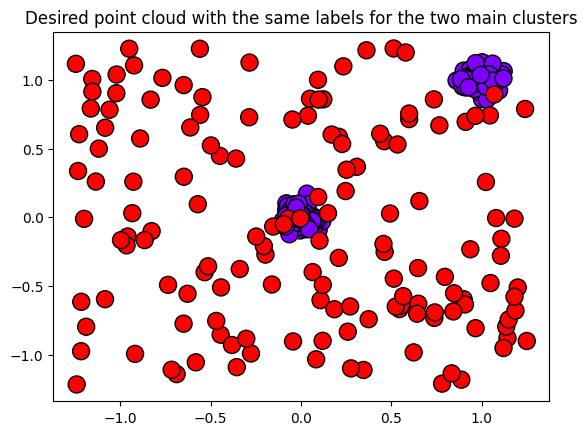

In [112]:
# 1. Generate the two main clusters with the same labels
cluster_std = 0.05  # Reduced spread within each cluster
X1, y1 = make_blobs(n_samples=100, centers=[[0, 0]], cluster_std=cluster_std)
X2, y2 = make_blobs(n_samples=100, centers=[[1, 1]], cluster_std=cluster_std)  # Increased distance between centers

# 2. Generate random points around the main clusters
r = np.random.rand(150, 2) * 2.5 - [1.25, 1.25]  # Increased the range for the random points
mask = np.logical_or(np.linalg.norm(r - [0, 0], axis=1) > 0.5, 
                     np.linalg.norm(r - [1, 1], axis=1) > 0.5)
X3 = r[mask]

# Combine the datasets
X = np.vstack([X1, X2, X3])
y = np.hstack([y1, y2, [2]*len(X3)])

# Visualize
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow', edgecolor='k', s=150)
plt.title('Desired point cloud with the same labels for the two main clusters')
plt.show()

X = X.T
y = y.reshape((1, y.shape[0]))

## Model

In [113]:
def initialisation(dimensions):
    
    parameters = {}

    for l in range(1, len(dimensions)):
        parameters['W' + str(l)] = np.random.randn(dimensions[l], dimensions[l-1])
        parameters['b' + str(l)] = np.random.randn(dimensions[l], 1)

    return parameters

In [114]:
def forward_propagation(X, parameters):

    activations = {'A0' : X}

    for l in range(1, (len(parameters)//2) + 1):
        Z = parameters["W" + str(l)] @ activations["A" + str(l-1)] \
            + parameters["b" + str(l)]
        activations["A" + str(l)] = 1 / (1 + np.exp(-Z))
    
    return activations

In [115]:
def back_propagation(X, y, activations, parameters):

    m = y.shape[1]
    gradients = {}
    dZ = activations['A' + str(len(parameters)//2)] - y

    for l in range(len(parameters)//2, 0, -1):
        gradients["dW" + str(l)] = 1 / m * dZ @ activations['A' + str(l-1)].T
        gradients["db" + str(l)] = 1 / m * np.sum(dZ, axis = 1, keepdims=True)
        if l > 1:
            dZ = parameters['W' + str(l)].T @ dZ * \
                activations['A' + str(l - 1)] * (1 - activations['A' + str(l - 1)])

    return gradients

In [116]:
def update(parameters, gradients, alpha):
    
    for l in range(len(parameters)//2, 0, -1):
        parameters['W' + str(l)] = parameters['W' + str(l)] - alpha * gradients['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - alpha * gradients['db' + str(l)]

    return parameters

In [117]:
def predict(X, parameters):
    activations = forward_propagation(X, parameters)
    return activations['A' + str(len(parameters)//2)] >= 0.5

In [118]:
X.shape
y.shape

(1, 350)

In [119]:
def neural_network(X_train, y_train, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 400):
    
    # initialisation
    np.random.seed(0)
    dimensions = list(hidden_layers)
    dimensions.insert(0, X_train.shape[0])
    dimensions.append(y_train.shape[0])
    parameters = initialisation(dimensions)
    
    train_loss = []
    train_acc = []

    # Generate a mesh grid
    x_min, x_max = X_train[0, :].min() - 1, X_train[0, :].max() + 1
    y_min, y_max = y_train[0, :].min() - 2, y_train[0, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # training
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X_train, parameters)
        gradients = back_propagation(X_train, y_train, activations, parameters)
        parameters = update(parameters, gradients, learning_rate)

        if i % 10 == 0:
            L = len(parameters) // 2
            train_loss.append(log_loss(y_train.flatten(), activations['A' + str(L)].flatten()))
            y_pred = predict(X_train, parameters)
            current_accuracy = accuracy_score(y_train.flatten(), y_pred.flatten())
            train_acc.append(current_accuracy)

    # predict the output for each point
    Z = predict(np.c_[xx.ravel(), yy.ravel()].T, parameters)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize = (14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='train loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_acc, label='train acc')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.contour(xx, yy, Z, colors='red', levels=[0.5])
    plt.contourf(xx, yy, Z, alpha=0.75, cmap='summer')
    plt.scatter(X_train[0,:], X_train[1,:], c=y_train, cmap='summer')

    plt.show()

    return parameters


## Training

100%|██████████| 5000/5000 [00:04<00:00, 1224.35it/s]


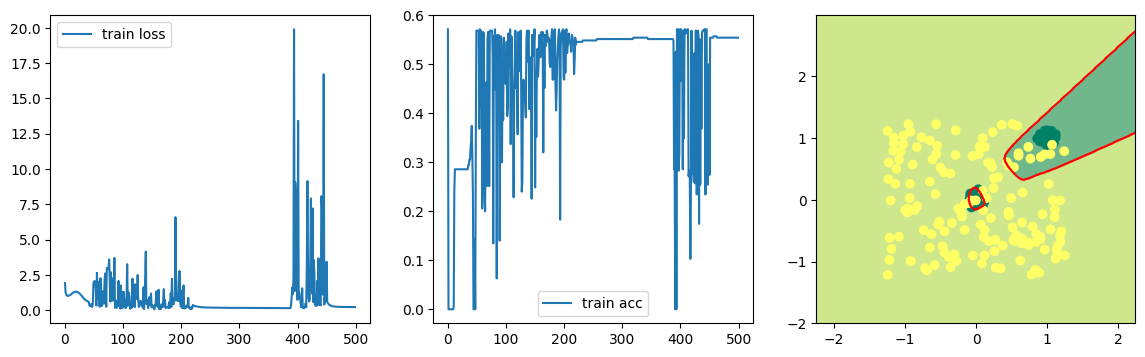

In [124]:
parameters = neural_network(X, y, hidden_layers=(32, 32, 32), n_iter=5000, learning_rate=0.1)